In [1]:
import sys
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import numpy as np
import os
import itertools
import socket
from datetime import datetime
from pandas.tseries.offsets import DateOffset
import matplotlib.pyplot as plt
import time
import holidays
import pycountry
import optuna

import seaborn as sns
import matplotlib.pyplot as plt
from termcolor import colored
from IPython.display import display
from IPython.display import clear_output

In [2]:
import tensorflow as tf
if tf.config.list_physical_devices('GPU'):
    print("GPU is available.")
else:
    print("GPU is not available.")

GPU is not available.


In [3]:
from catboost import CatBoostClassifier
from catboost.utils import get_gpu_device_count

# Check available GPUs
gpu_count = get_gpu_device_count()
if gpu_count > 0:
    print(f"GPU is available with {gpu_count} GPU(s).")
else:
    print("No GPU detected. Ensure your setup is correct.")

# Test CatBoost with GPU
try:
    model = CatBoostClassifier(task_type="GPU", devices='0')  # Specify GPU
    device = 'gpu'
    print("CatBoost can use the GPU.")
        
except Exception as e:
    device = 'cpu'
    print(f"Error: {e}")

No GPU detected. Ensure your setup is correct.
CatBoost can use the GPU.


In [4]:
# Declare important variables
train_path = 'train.csv'
test_path = 'test.csv'
submission_path = 'sample_submission.csv'
target_variable = 'num_sold'
SEED = 69
skip_hypertuning = True
cat_encoder_type = 'OneHotEncoder' #OneHotEncoder, FrequencyEncoder, None

In [5]:
def load_dataframes(path1: str, path2: str, format1: str = "csv", format2: str = "csv") -> tuple:

    loaders = {
        "csv": pd.read_csv,
        "excel": pd.read_excel,
        "json": pd.read_json,
    }

    if format1 not in loaders or format2 not in loaders:
        raise ValueError("Unsupported format. Supported formats: 'csv', 'excel', 'json'.")

    # Load the dataframes using appropriate loaders
    df1 = loaders[format1](path1)
    df2 = loaders[format2](path2)

    print(f"Loading data from {os.getcwd()}")
    
    return df1, df2

In [6]:
train, test = load_dataframes(train_path,test_path)

Loading data from C:\Users\zchodan\OneDrive - Franklin Templeton\Documents\Python\Kaggle\Playground Series\s5e1 - Sticker Sales


In [7]:
# add the 'dataset' column to distinguish train and test data
train['dataset'] = 'train'
test['dataset'] = 'test'

# concatenate the datasets with the added 'dataset' column
df_original = pd.concat([train, test], axis=0).reset_index(drop=True)
df_original = df_original.rename(columns={target_variable: 'y'})

In [8]:
#plot_kde_grid(df_train,n_cols=4,figsize=(12,8))

In [9]:
#plot_kde_grid(df_solve,n_cols=4,figsize=(9,6))

In [10]:
def get_num_cols(df: pd.DataFrame):
    num_cols = df.select_dtypes(include=['number']).columns.to_list()
    
    return num_cols

def get_cat_cols(df: pd.DataFrame):
    cat_cols = df.select_dtypes(include=['object', 'string', 'category']).columns.tolist()  

    return cat_cols

In [11]:
def describe_dataframe(df_to_use: pd.DataFrame, name: str = 'DataFrame', nrows: int = 3, plots: bool = False, info: bool = True) -> None:
    '''
    Function to describe the DataFrame with summary statistics, missing value count,
    unique value count, and duplicate count. It also displays plots for missing and unique values.
    
    Parameters:
    - df: The DataFrame to describe.
    - name: The name to display in the summary (default is 'DataFrame').
    - nrows: The number of rows to display from the top and bottom (default is 3).
    - plots: Whether to display bar plots for missing and unique values (default is False).
    - info: Whether to display the styled DataFrame (default is True).
    '''

    df = df_to_use.copy()   
    
    # Create summary DataFrame
    inf = pd.DataFrame(df.dtypes).reset_index().rename(columns={'index':'column', 0:'type'})
    
    # Missing values
    df_missing = pd.DataFrame(df.isnull().sum()).reset_index().rename(columns={'index':'column', 0:'missing'})
    df_missing['pct_missing'] = (df_missing['missing'] / df.shape[0]) * 100
    
    # Unique values
    df_unique = pd.DataFrame(df.nunique()).reset_index().rename(columns={'index':'column', 0:'unique'})
    
    # Combine summary information
    inf['missing'] = df_missing['missing']
    inf['pct_missing'] = df_missing['pct_missing']
    inf['unique'] = df_unique['unique']
    inf['duplicate'] = df.duplicated().sum()
    inf['count'] = df.shape[0]

    # Descriptive statistics
    desc = pd.DataFrame(df.describe(include='all').transpose())
    if 'min' in desc.columns.tolist():
        inf['min'] = desc['min'].values
        inf['max'] = desc['max'].values
        inf['avg'] = desc['mean'].values
        inf['std dev'] = desc['std'].values
    if 'top' in desc.columns.tolist():
        inf['top value'] = desc['top'].values
        inf['Freq'] = desc['freq'].values 
    
    # Display styled DataFrame
    if info:
        display(inf.style.background_gradient(subset=['missing','pct_missing'], cmap='Reds').background_gradient(subset='unique', cmap='Greens'))

    if nrows != 0 :
        # Display top and bottom nrows of the DataFrame
        print(f"\n---------- {name} Overview ----------:")
        print(f"{name} has {df.shape[0]} rows and {df.shape[1]} columns\n")
        display(df.head(nrows))
        display(df.tail(nrows))
    
    # Plot missing values if any
    if plots and df_missing['missing'].sum() > 0:
        fig, ax = plt.subplots(1, 1, figsize=(24, 5))
        sns.barplot(df_missing[df_missing['missing'] > 0], x='column', y='missing', ax=ax)
        ax.set_title(f'{name} missing Values') 
        ax.bar_label(ax.containers[0])
        plt.tight_layout()
        plt.show()
    
        # Plot unique values
        fig, ax = plt.subplots(1, 1, figsize=(24, 5))
        sns.barplot(df_unique[df_unique['unique'] > 0], x='column', y='unique', ax=ax)
        ax.set_title(f'{name} Unique Values')
        ax.bar_label(ax.containers[0])
        plt.tight_layout()
        plt.show()

In [12]:
describe_dataframe(df_original, name='Insurance Data', nrows=0, plots=False, info=True)

,column,type,missing,pct_missing,unique,duplicate,count,min,max,avg,std dev,top value,Freq
0,id,int64,0,0.000000,328680,0,328680,0.000000,328679.000000,164339.500000,94881.887576,nan,nan
1,date,object,0,0.000000,3652,0,328680,nan,nan,nan,nan,2010-01-01,90
2,country,object,0,0.000000,6,0,328680,nan,nan,nan,nan,Canada,54780
3,store,object,0,0.000000,3,0,328680,nan,nan,nan,nan,Discount Stickers,109560
4,product,object,0,0.000000,5,0,328680,nan,nan,nan,nan,Holographic Goose,65736
5,y,float64,107421,32.682548,4037,0,328680,5.000000,5939.000000,752.527382,690.165445,nan,nan
6,dataset,object,0,0.000000,2,0,328680,nan,nan,nan,nan,train,230130


<Figure size 1000x600 with 0 Axes>

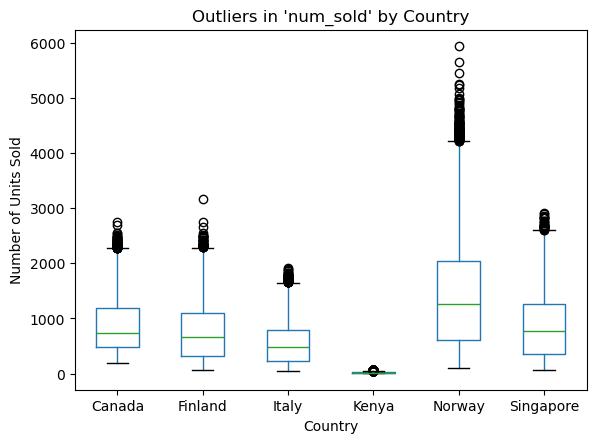

In [13]:
plt.figure(figsize=(10, 6))
df_original.boxplot(column='y', by='country', grid=False)
plt.title("Outliers in 'num_sold' by Country")
plt.suptitle("")  # Removes the default matplotlib title
plt.ylabel('Number of Units Sold')
plt.xlabel('Country')
plt.show()

In [14]:
# Calculate Outlier Bounds Using IQR
# Calculating Interquartile Range (IQR) to identify potential outliers
# Filtering rows where 'num_sold' is outside the lower and upper bounds

# Recalculate Q1, Q3, and IQR
Q1 = df_original['y'].quantile(0.25)
Q3 = df_original['y'].quantile(0.75)
IQR = Q3 - Q1

# Define lower and upper bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter outliers
outliers = df_original[(df_original['y'] < lower_bound) | (df_original['y'] > upper_bound)]
print(f"Number of Outliers: {len(outliers)}")

Number of Outliers: 6630


In [15]:
# Group outliers by country
outliers_by_country = outliers.groupby('country').size()
print("Outliers by Country:")
print(outliers_by_country)

# Group outliers by store
outliers_by_store = outliers.groupby('store').size()
print("Outliers by Store:")
print(outliers_by_store)

# Group outliers by product
outliers_by_product = outliers.groupby('product').size()
print("Outliers by Product:")
print(outliers_by_product)

Outliers by Country:
country
Canada         11
Finland        11
Norway       6521
Singapore      87
dtype: int64
Outliers by Store:
store
Discount Stickers          1
Premium Sticker Mart    4175
Stickers for Less       2454
dtype: int64
Outliers by Product:
product
Kaggle                4169
Kaggle Tiers          2347
Kerneler                 2
Kerneler Dark Mode     112
dtype: int64


In [16]:
def clean_dataframe(df_to_use: pd.DataFrame, impute_num_nulls: bool = True, fill_cat_nulls: bool = True) -> None:
    df = df_to_use.copy()

    # Convert date column from object to datetime
    df['date'] = pd.to_datetime(df['date'])
    
    # Filter columns where the type is either 'float' or 'int' and there are missing values
    numeric_cols = df.select_dtypes(include=['number']).columns
    missing_numeric_columns = [
        col for col in numeric_cols if df[col].isnull().sum() > 0
    ]

    # Target field 'num_sold' is missing some values, we do not want to impute them
    if 'y' in missing_numeric_columns:
        missing_numeric_columns.remove('y')
    
    # Fill nulls in numeric columns with the median
    if impute_num_nulls:       
        for column in missing_numeric_columns:
            mdn = df[column].median()
            df[column] = df[column].fillna(mdn)

    
    # Get category columns
    if fill_cat_nulls:
        cat_cols = df.select_dtypes(include=['object', 'string','category']).columns.tolist()  
        # Fill missing values in object columns
        for column in cat_cols:
            df[column] = df[column].fillna('None')
    
    return df

In [17]:
df_original = clean_dataframe(df_original, impute_num_nulls = True, fill_cat_nulls=False)

In [18]:
describe_dataframe(df_original, name='Insurance Data', nrows=0, plots=False, info=True)

,column,type,missing,pct_missing,unique,duplicate,count,min,max,avg,std dev,top value,Freq
0,id,int64,0,0.000000,328680,0,328680,0.000000,328679.000000,164339.500000,94881.887576,nan,nan
1,date,datetime64[ns],0,0.000000,3652,0,328680,2010-01-01 00:00:00,2019-12-31 00:00:00,2014-12-31 12:00:00,nan,nan,nan
2,country,object,0,0.000000,6,0,328680,nan,nan,nan,nan,Canada,54780
3,store,object,0,0.000000,3,0,328680,nan,nan,nan,nan,Discount Stickers,109560
4,product,object,0,0.000000,5,0,328680,nan,nan,nan,nan,Holographic Goose,65736
5,y,float64,107421,32.682548,4037,0,328680,5.000000,5939.000000,752.527382,690.165445,nan,nan
6,dataset,object,0,0.000000,2,0,328680,nan,nan,nan,nan,train,230130


In [19]:
def get_holiday_name(country_code, date_obj):
    try:
        country_holiday = holidays.CountryHoliday(country_code, years=date_obj.year)
        return country_holiday.get(date_obj)
    except Exception as e:
        print(f"Error for country code {country_code} and date {date_obj}: {e}")
        return 'Invalid Holiday'
    return country_holiday.get(date_obj)

def get_country_code(country_name):
    try:
        country = pycountry.countries.get(name=country_name)
        return country.alpha_2  
    except KeyError:
        print(f"Unknown Country: {country_name}")
        return None

def get_holiday_for_row(row):
    country_code = get_country_code(row['country'])
    if country_code is None:
        return 'Unknown Country'     
    try:
        date_obj = row['date']
    except ValueError:
        print(f"Invalid Date: {row['date']}")
        return 'Invalid Date'

    return get_holiday_name(country_code, date_obj)


df_original['holiday'] = df_original.apply(get_holiday_for_row, axis=1)


In [20]:
# Inserting holiday takes a while, so lets split here so we can skip whil testing
df = df_original.copy()

In [21]:

df['Year'] = df['date'].dt.year
df['Quarter'] = df['date'].dt.quarter
df['Month'] = df['date'].dt.month
df['day_of_month'] = df['date'].dt.day
df['day_of_week'] = df['date'].dt.day_name()
#df['day_of_year'] = df['date'].dt.dayofyear
df['week_of_year'] = df['date'].dt.isocalendar().week

df['day_of_month_sin'] = np.sin(2 * np.pi * df['day_of_month'] / 31.0)
df['day_of_month_cos'] = np.cos(2 * np.pi * df['day_of_month'] / 31.0)
#df['day_of_year_sin'] = np.sin(2 * np.pi * df['day_of_year'] / 365.0)
#df['day_of_year_cos'] = np.cos(2 * np.pi * df['day_of_year'] / 365.0)
df['month_sin'] = np.sin(2 * np.pi * df['Month'] / 12.0)
df['month_cos'] = np.cos(2 * np.pi * df['Month'] / 12.0)
df['year_sin'] = np.sin(2 * np.pi * df['Year'] / 7.0)
df['year_cos'] = np.cos(2 * np.pi * df['Year'] / 7.0)
df['Group']=(df['Year']-2010)*48+df['Month']*4+df['day_of_month']//7


df['Quarter'] = df['Quarter'].astype('str')
df['Month'] = df['Month'].astype('str')
df['day_of_week'] = df['day_of_week'].astype('str')
#df['day_of_year'] = df['day_of_year'].astype('str')
df['week_of_year'] = df['week_of_year'].astype('str')

In [22]:
RMV = ['y','dataset','id','date']
FEATURES = [c for c in df.columns if not c in RMV]

CATS = []
HIGH_CARDINALITY = []
print(f"THE {len(FEATURES)} BASIC FEATURES ARE:")

for c in FEATURES:
    ftype = "numerical"
    if df[c].dtype=="object":
        CATS.append(c)
        df[c] = df[c].fillna("NAN")
        df[c],_ = df[c].factorize() # Turns cats into integers
        df[c] -= df[c].min() # Normalize to start from 0 so range is [0 : n-1]
        ftype = "categorical"
    if df[c].dtype=="int64":
        df[c] = df[c].astype("int32")
    elif df[c].dtype=="float64":
        df[c] = df[c].astype("float32")

    n = df[c].nunique()
    print(f"{c} ({ftype}) with {n} unique values")
    if n>=9: HIGH_CARDINALITY.append(c)

print("\nTHE FOLLOWING HAVE 9 OR MORE UNIQUE VALUES:", HIGH_CARDINALITY )

THE 17 BASIC FEATURES ARE:
country (categorical) with 6 unique values
store (categorical) with 3 unique values
product (categorical) with 5 unique values
holiday (categorical) with 75 unique values
Year (numerical) with 10 unique values
Quarter (categorical) with 4 unique values
Month (categorical) with 12 unique values
day_of_month (numerical) with 31 unique values
day_of_week (categorical) with 7 unique values
week_of_year (categorical) with 53 unique values
day_of_month_sin (numerical) with 31 unique values
day_of_month_cos (numerical) with 16 unique values
month_sin (numerical) with 8 unique values
month_cos (numerical) with 8 unique values
year_sin (numerical) with 7 unique values
year_cos (numerical) with 4 unique values
Group (numerical) with 481 unique values

THE FOLLOWING HAVE 9 OR MORE UNIQUE VALUES: ['holiday', 'Year', 'Month', 'day_of_month', 'week_of_year', 'day_of_month_sin', 'day_of_month_cos', 'Group']


In [23]:
describe_dataframe(df, name='Sales Data', nrows=0, plots=False, info=True)

,column,type,missing,pct_missing,unique,duplicate,count,min,max,avg,std dev,top value,Freq
0,id,int64,0,0.000000,328680,0,328680,0.000000,328679.000000,164339.500000,94881.887576,nan,nan
1,date,datetime64[ns],0,0.000000,3652,0,328680,2010-01-01 00:00:00,2019-12-31 00:00:00,2014-12-31 12:00:00,nan,nan,nan
2,country,int32,0,0.000000,6,0,328680,0.000000,5.000000,2.500000,1.707828,nan,nan
3,store,int32,0,0.000000,3,0,328680,0.000000,2.000000,1.000000,0.816498,nan,nan
4,product,int32,0,0.000000,5,0,328680,0.000000,4.000000,2.000000,1.414216,nan,nan
5,y,float64,107421,32.682548,4037,0,328680,5.000000,5939.000000,752.527382,690.165445,nan,nan
6,dataset,object,0,0.000000,2,0,328680,nan,nan,nan,nan,train,230130
7,holiday,int32,0,0.000000,75,0,328680,0.000000,74.000000,4.791804,5.508516,nan,nan
8,Year,int32,0,0.000000,10,0,328680,2010.000000,2019.000000,2014.499726,2.871904,nan,nan
9,Quarter,int32,0,0.000000,4,0,328680,0.000000,3.000000,1.508762,1.117021,nan,nan


In [24]:
# replace with zero 
# Drop rows where 'dataset' is 'train' and 'num_sold' is NaN
df = df[~((df['dataset'] == 'train') & (df['y'].isna()))]

In [25]:
# Encoding categorical variables (country, store, product) as dummy variables
# Avoiding the dummy variable trap by dropping the first category in each column

df = pd.get_dummies(df, columns=['country', 'store', 'product'], dtype=int, drop_first=True)

In [26]:
# sns.set(rc={'figure.figsize':(24,8)})
# ax=sns.lineplot(data=df_train,x='Day of Year',y='y')
# ax.axes.set_title("\nBasic Time Series of Sales\n",fontsize=20);

In [27]:
# sns.set(rc={'figure.figsize':(24,8)})
# ax=sns.lineplot(data=df_train,x='Week of Year',y='y')
# ax.axes.set_title("\nBasic Time Series of Sales\n",fontsize=20);

In [28]:
# sns.set(rc={'figure.figsize':(24,8)})
# ax=sns.lineplot(data=df_train,x='Month',y='y')
# ax.axes.set_title("\nBasic Time Series of Sales\n",fontsize=20);

In [29]:
# Splitting the training dataset into train and validation sets
# Ensuring the split preserves the time series order

# Separate train and test datasets
train_df = df[df['dataset'] == 'train'].drop(columns=['dataset'], errors='ignore')
test_df = df[df['dataset'] == 'test'].drop(columns=['dataset'], errors='ignore')


# Drop unnecessary columns from both datasets
train_df = train_df.drop(columns=['id'], errors='ignore')
test_df = test_df.drop(columns=['y'], errors='ignore')

# Sort training data by date to preserve time series order
train_df = train_df.sort_values(by='date')

# Let's define a split date or index
train_size = int(len(train_df) * 0.86)  # 80% for training
df_train = train_df.iloc[:train_size]
df_test = train_df.iloc[train_size:]



In [ ]:
for c in
    ## Target Encode Important Categories
    # Step 1: Calculate the target encoding for the training data (mean price for each city)
    df_train['holiday_encoded'] = np.nan
    
    # Calculate cumulative encoding for the training set (up to each time point)
    overall_mean = df_train['y'].mean()
    holiday_mean = df_train.groupby('holiday')['y'].expanding().mean().reset_index(level=0, drop=True)
    
    # Apply smoothing to the cumulative encoding
    smoothing_factor = 10  # A smoothing factor (hyperparameter)
    df_train['holiday_encoded'] = (holiday_mean * smoothing_factor + overall_mean) / (smoothing_factor + 1)
    
    # Step 2: Apply the same encoding to the test data (use training data encoding)
    # We map the mean encoded values from the training set to the test set
    holiday_mean_dict = df_train.groupby('holiday')['holiday_encoded'].last().to_dict()
    
    # Apply encoding to the test set using the mapping from training data
    df_test['holiday_encoded'] = df_test['holiday'].map(holiday_mean_dict).fillna(overall_mean)  # Fill missing with overall mean

In [31]:
# Apply a logarithmic transformation to 'num_sold' to reduce skewness and stabilize variance.
# This transformation helps to handle outliers by compressing large values, making the data 
# more suitable for statistical analysis and modeling.
df_test['y'] = np.log(df_test['y'])
df_train['y'] = np.log(df_train['y'])

In [33]:
# Separate features and target
x_train = df_train.drop(['y'], axis=1)
y_train = df_train['y']
x_test = df_test.drop(['y'], axis=1)
y_test = df_test['y']

# Drop the 'date' column after feature extraction
x_train = x_train.drop(columns=['date'], errors='ignore')
x_test = x_test.drop(columns=['date'], errors='ignore')

In [35]:
from sklearn.model_selection import TimeSeriesSplit
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

# Define the objective function for Optuna, which evaluates LightGBM's performance
def objective(trial):
    # Suggest hyperparameter values to be optimized by Optuna
    params = {
        "num_leaves": trial.suggest_int("num_leaves", 16, 128),  # Maximum leaves in one tree
        "learning_rate": trial.suggest_float("learning_rate", 1e-4, 1e-1, log=True),  # Learning rate for gradient boosting
        "n_estimators": trial.suggest_int("n_estimators", 500, 1500, step=100),  # Number of boosting rounds
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),  # Fraction of samples used per iteration
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),  # Fraction of features used for each tree
        "random_state": SEED,  # Ensures reproducibility
    }
    
    # Use TimeSeriesSplit to preserve temporal order during cross-validation
    tscv = TimeSeriesSplit(n_splits=3)
    model = LGBMRegressor(**params)  # Initialize the LightGBM model with current parameters
    
    errors = []  # List to store validation errors for each fold
    for train_index, val_index in tscv.split(x_train):  # Split training data for cross-validation
        x_train_cv, X_val_cv = x_train.iloc[train_index], x_train.iloc[val_index]  # Train/validation splits
        y_train_cv, y_val_cv = y_train.iloc[train_index], y_train.iloc[val_index]
        model.fit(x_train_cv, y_train_cv)  # Train the model on the current fold
        y_val_pred = model.predict(X_val_cv)  # Predict on the validation set
        errors.append(mean_squared_error(y_val_cv, y_val_pred))  # Calculate and store MSE
        # Calculate MAPE and store it
        
    # Calculate the Root Mean Squared Error (RMSE) for the current trial
    rmse = np.sqrt(np.mean(errors))
    return rmse  # Return RMSE as the objective value for Optuna to minimize

# Initialize an Optuna study for hyperparameter optimization
study = optuna.create_study(direction="minimize")  # Minimize RMSE
study.optimize(objective, n_trials=25)  # Optimize the objective function over 30 trials

# Print the best hyperparameters found during optimization
print("Best trial:", study.best_trial.params)

[I 2025-01-14 13:15:26,623] A new study created in memory with name: no-name-05f66994-c41f-4436-a878-c2cfeef6d406


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000669 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 601
[LightGBM] [Info] Number of data points in the train set: 47572, number of used features: 26
[LightGBM] [Info] Start training from score 5.934451
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000699 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 681
[LightGBM] [Info] Number of data points in the train set: 95142, number of used features: 26
[LightGBM] [Info] Start training from score 5.950947
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001267 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough,

[I 2025-01-14 13:15:42,481] Trial 0 finished with value: 0.9022900111569755 and parameters: {'num_leaves': 56, 'learning_rate': 0.0007610300275137323, 'n_estimators': 1400, 'subsample': 0.5728608342531958, 'colsample_bytree': 0.5385785384400743}. Best is trial 0 with value: 0.9022900111569755.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000680 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 601
[LightGBM] [Info] Number of data points in the train set: 47572, number of used features: 26
[LightGBM] [Info] Start training from score 5.934451
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001574 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 681
[LightGBM] [Info] Number of data points in the train set: 95142, number of used features: 26
[LightGBM] [Info] Start training from score 5.950947
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001767 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough,

[I 2025-01-14 13:15:48,377] Trial 1 finished with value: 1.4202408067058039 and parameters: {'num_leaves': 52, 'learning_rate': 0.00027296067020771933, 'n_estimators': 500, 'subsample': 0.6204542498938788, 'colsample_bytree': 0.6073588931713898}. Best is trial 0 with value: 0.9022900111569755.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000620 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 601
[LightGBM] [Info] Number of data points in the train set: 47572, number of used features: 26
[LightGBM] [Info] Start training from score 5.934451
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001415 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 681
[LightGBM] [Info] Number of data points in the train set: 95142, number of used features: 26
[LightGBM] [Info] Start training from score 5.950947
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001668 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough,

[I 2025-01-14 13:16:08,069] Trial 2 finished with value: 1.2091217785191164 and parameters: {'num_leaves': 110, 'learning_rate': 0.0003704031184796096, 'n_estimators': 1100, 'subsample': 0.6855293832063633, 'colsample_bytree': 0.6193010799198598}. Best is trial 0 with value: 0.9022900111569755.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000699 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 601
[LightGBM] [Info] Number of data points in the train set: 47572, number of used features: 26
[LightGBM] [Info] Start training from score 5.934451
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001603 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 681
[LightGBM] [Info] Number of data points in the train set: 95142, number of used features: 26
[LightGBM] [Info] Start training from score 5.950947
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002848 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough,

[I 2025-01-14 13:16:25,214] Trial 3 finished with value: 0.11547877533231965 and parameters: {'num_leaves': 80, 'learning_rate': 0.023071906204228377, 'n_estimators': 1300, 'subsample': 0.8654913173668192, 'colsample_bytree': 0.7385625242886689}. Best is trial 3 with value: 0.11547877533231965.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000359 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 601
[LightGBM] [Info] Number of data points in the train set: 47572, number of used features: 26
[LightGBM] [Info] Start training from score 5.934451
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001165 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 681
[LightGBM] [Info] Number of data points in the train set: 95142, number of used features: 26
[LightGBM] [Info] Start training from score 5.950947
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001351 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough,

[I 2025-01-14 13:16:33,630] Trial 4 finished with value: 0.11113639888659647 and parameters: {'num_leaves': 24, 'learning_rate': 0.09928613465265598, 'n_estimators': 1500, 'subsample': 0.5096785353685278, 'colsample_bytree': 0.5906224362052088}. Best is trial 4 with value: 0.11113639888659647.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000637 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 601
[LightGBM] [Info] Number of data points in the train set: 47572, number of used features: 26
[LightGBM] [Info] Start training from score 5.934451
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001334 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 681
[LightGBM] [Info] Number of data points in the train set: 95142, number of used features: 26
[LightGBM] [Info] Start training from score 5.950947
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002373 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough,

[I 2025-01-14 13:16:52,774] Trial 5 finished with value: 1.1339349200227622 and parameters: {'num_leaves': 79, 'learning_rate': 0.0003457193217291598, 'n_estimators': 1300, 'subsample': 0.9232112316987711, 'colsample_bytree': 0.6778298786240577}. Best is trial 4 with value: 0.11113639888659647.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000553 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 601
[LightGBM] [Info] Number of data points in the train set: 47572, number of used features: 26
[LightGBM] [Info] Start training from score 5.934451
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001240 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 681
[LightGBM] [Info] Number of data points in the train set: 95142, number of used features: 26
[LightGBM] [Info] Start training from score 5.950947
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001746 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough,

[I 2025-01-14 13:17:04,301] Trial 6 finished with value: 0.12048822926380615 and parameters: {'num_leaves': 107, 'learning_rate': 0.009845248268836634, 'n_estimators': 600, 'subsample': 0.9965762059079977, 'colsample_bytree': 0.7744659673570922}. Best is trial 4 with value: 0.11113639888659647.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000654 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 601
[LightGBM] [Info] Number of data points in the train set: 47572, number of used features: 26
[LightGBM] [Info] Start training from score 5.934451
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001281 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 681
[LightGBM] [Info] Number of data points in the train set: 95142, number of used features: 26
[LightGBM] [Info] Start training from score 5.950947
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001894 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough,

[I 2025-01-14 13:17:10,835] Trial 7 finished with value: 0.11144720622986712 and parameters: {'num_leaves': 21, 'learning_rate': 0.022018460604889396, 'n_estimators': 900, 'subsample': 0.9050002733557506, 'colsample_bytree': 0.9972954790668409}. Best is trial 4 with value: 0.11113639888659647.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000419 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 601
[LightGBM] [Info] Number of data points in the train set: 47572, number of used features: 26
[LightGBM] [Info] Start training from score 5.934451
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001107 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 681
[LightGBM] [Info] Number of data points in the train set: 95142, number of used features: 26
[LightGBM] [Info] Start training from score 5.950947
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001390 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough,

[I 2025-01-14 13:17:23,444] Trial 8 finished with value: 0.11614388923242498 and parameters: {'num_leaves': 66, 'learning_rate': 0.01821669734371489, 'n_estimators': 1000, 'subsample': 0.709727684554111, 'colsample_bytree': 0.560123274391349}. Best is trial 4 with value: 0.11113639888659647.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000674 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 601
[LightGBM] [Info] Number of data points in the train set: 47572, number of used features: 26
[LightGBM] [Info] Start training from score 5.934451
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001435 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 681
[LightGBM] [Info] Number of data points in the train set: 95142, number of used features: 26
[LightGBM] [Info] Start training from score 5.950947
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002252 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough,

[I 2025-01-14 13:17:32,203] Trial 9 finished with value: 1.1585342412623774 and parameters: {'num_leaves': 45, 'learning_rate': 0.00042350111091748414, 'n_estimators': 800, 'subsample': 0.9561479693353355, 'colsample_bytree': 0.8346588621951668}. Best is trial 4 with value: 0.11113639888659647.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000637 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 601
[LightGBM] [Info] Number of data points in the train set: 47572, number of used features: 26
[LightGBM] [Info] Start training from score 5.934451
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001314 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 681
[LightGBM] [Info] Number of data points in the train set: 95142, number of used features: 26
[LightGBM] [Info] Start training from score 5.950947
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001767 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough,

[I 2025-01-14 13:17:40,009] Trial 10 finished with value: 0.11360639357794672 and parameters: {'num_leaves': 22, 'learning_rate': 0.09488815380336711, 'n_estimators': 1500, 'subsample': 0.5116773823761371, 'colsample_bytree': 0.9440367060605828}. Best is trial 4 with value: 0.11113639888659647.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000659 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 601
[LightGBM] [Info] Number of data points in the train set: 47572, number of used features: 26
[LightGBM] [Info] Start training from score 5.934451
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001607 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 681
[LightGBM] [Info] Number of data points in the train set: 95142, number of used features: 26
[LightGBM] [Info] Start training from score 5.950947
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002373 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough,

[I 2025-01-14 13:17:44,746] Trial 11 finished with value: 0.11615220759411447 and parameters: {'num_leaves': 17, 'learning_rate': 0.09543008404892489, 'n_estimators': 900, 'subsample': 0.8145947499531339, 'colsample_bytree': 0.9648629881280442}. Best is trial 4 with value: 0.11113639888659647.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000668 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 601
[LightGBM] [Info] Number of data points in the train set: 47572, number of used features: 26
[LightGBM] [Info] Start training from score 5.934451
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001251 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 681
[LightGBM] [Info] Number of data points in the train set: 95142, number of used features: 26
[LightGBM] [Info] Start training from score 5.950947
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001818 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough,

[I 2025-01-14 13:17:55,637] Trial 12 finished with value: 0.15473767382277318 and parameters: {'num_leaves': 32, 'learning_rate': 0.003548906396170598, 'n_estimators': 1100, 'subsample': 0.8320817142166884, 'colsample_bytree': 0.8727563707672561}. Best is trial 4 with value: 0.11113639888659647.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000629 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 601
[LightGBM] [Info] Number of data points in the train set: 47572, number of used features: 26
[LightGBM] [Info] Start training from score 5.934451
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001467 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 681
[LightGBM] [Info] Number of data points in the train set: 95142, number of used features: 26
[LightGBM] [Info] Start training from score 5.950947
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001993 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough,

[I 2025-01-14 13:18:01,442] Trial 13 finished with value: 0.10952964165000385 and parameters: {'num_leaves': 35, 'learning_rate': 0.037699447681958924, 'n_estimators': 700, 'subsample': 0.7693837530165157, 'colsample_bytree': 0.994155603614214}. Best is trial 13 with value: 0.10952964165000385.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000663 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 601
[LightGBM] [Info] Number of data points in the train set: 47572, number of used features: 26
[LightGBM] [Info] Start training from score 5.934451
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001306 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 681
[LightGBM] [Info] Number of data points in the train set: 95142, number of used features: 26
[LightGBM] [Info] Start training from score 5.950947
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001885 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough,

[I 2025-01-14 13:18:07,551] Trial 14 finished with value: 0.11244867308809377 and parameters: {'num_leaves': 38, 'learning_rate': 0.04758124857488313, 'n_estimators': 700, 'subsample': 0.7656189386587433, 'colsample_bytree': 0.71261409705729}. Best is trial 13 with value: 0.10952964165000385.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000634 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 601
[LightGBM] [Info] Number of data points in the train set: 47572, number of used features: 26
[LightGBM] [Info] Start training from score 5.934451
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001256 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 681
[LightGBM] [Info] Number of data points in the train set: 95142, number of used features: 26
[LightGBM] [Info] Start training from score 5.950947
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001857 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough,

[I 2025-01-14 13:18:15,789] Trial 15 finished with value: 0.23811733484984351 and parameters: {'num_leaves': 90, 'learning_rate': 0.004344564321177016, 'n_estimators': 500, 'subsample': 0.6455242352644194, 'colsample_bytree': 0.8793961507405915}. Best is trial 13 with value: 0.10952964165000385.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000682 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 601
[LightGBM] [Info] Number of data points in the train set: 47572, number of used features: 26
[LightGBM] [Info] Start training from score 5.934451
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001285 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 681
[LightGBM] [Info] Number of data points in the train set: 95142, number of used features: 26
[LightGBM] [Info] Start training from score 5.950947
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002305 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough,

[I 2025-01-14 13:18:29,951] Trial 16 finished with value: 0.14229385241214593 and parameters: {'num_leaves': 127, 'learning_rate': 0.008641885074043822, 'n_estimators': 700, 'subsample': 0.5030239059867223, 'colsample_bytree': 0.6496089961876197}. Best is trial 13 with value: 0.10952964165000385.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000494 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 601
[LightGBM] [Info] Number of data points in the train set: 47572, number of used features: 26
[LightGBM] [Info] Start training from score 5.934451
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000693 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 681
[LightGBM] [Info] Number of data points in the train set: 95142, number of used features: 26
[LightGBM] [Info] Start training from score 5.950947
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001362 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough,

[I 2025-01-14 13:18:41,275] Trial 17 finished with value: 0.7462725676195038 and parameters: {'num_leaves': 35, 'learning_rate': 0.0013687846773296336, 'n_estimators': 1200, 'subsample': 0.7492752966635511, 'colsample_bytree': 0.5036475036952318}. Best is trial 13 with value: 0.10952964165000385.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000673 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 601
[LightGBM] [Info] Number of data points in the train set: 47572, number of used features: 26
[LightGBM] [Info] Start training from score 5.934451
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001306 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 681
[LightGBM] [Info] Number of data points in the train set: 95142, number of used features: 26
[LightGBM] [Info] Start training from score 5.950947
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002536 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough,

[I 2025-01-14 13:18:55,561] Trial 18 finished with value: 0.11194286369611825 and parameters: {'num_leaves': 59, 'learning_rate': 0.04678111852857143, 'n_estimators': 1500, 'subsample': 0.5917627295176623, 'colsample_bytree': 0.791070387576193}. Best is trial 13 with value: 0.10952964165000385.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000903 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 601
[LightGBM] [Info] Number of data points in the train set: 47572, number of used features: 26
[LightGBM] [Info] Start training from score 5.934451
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001385 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 681
[LightGBM] [Info] Number of data points in the train set: 95142, number of used features: 26
[LightGBM] [Info] Start training from score 5.950947
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002253 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough,

[I 2025-01-14 13:19:02,019] Trial 19 finished with value: 0.11060930323892267 and parameters: {'num_leaves': 30, 'learning_rate': 0.04547729864340554, 'n_estimators': 800, 'subsample': 0.7590975266169664, 'colsample_bytree': 0.9020217254696885}. Best is trial 13 with value: 0.10952964165000385.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000701 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 601
[LightGBM] [Info] Number of data points in the train set: 47572, number of used features: 26
[LightGBM] [Info] Start training from score 5.934451
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001772 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 681
[LightGBM] [Info] Number of data points in the train set: 95142, number of used features: 26
[LightGBM] [Info] Start training from score 5.950947
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002395 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough,

[I 2025-01-14 13:19:09,876] Trial 20 finished with value: 0.12878772473136654 and parameters: {'num_leaves': 44, 'learning_rate': 0.006776074020800661, 'n_estimators': 700, 'subsample': 0.8084050753365349, 'colsample_bytree': 0.9186992191534045}. Best is trial 13 with value: 0.10952964165000385.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000666 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 601
[LightGBM] [Info] Number of data points in the train set: 47572, number of used features: 26
[LightGBM] [Info] Start training from score 5.934451
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001247 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 681
[LightGBM] [Info] Number of data points in the train set: 95142, number of used features: 26
[LightGBM] [Info] Start training from score 5.950947
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002512 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough,

[I 2025-01-14 13:19:15,822] Trial 21 finished with value: 0.11215086359685163 and parameters: {'num_leaves': 27, 'learning_rate': 0.05624509533617812, 'n_estimators': 900, 'subsample': 0.7647250655900052, 'colsample_bytree': 0.904520491073572}. Best is trial 13 with value: 0.10952964165000385.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000647 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 601
[LightGBM] [Info] Number of data points in the train set: 47572, number of used features: 26
[LightGBM] [Info] Start training from score 5.934451
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001285 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 681
[LightGBM] [Info] Number of data points in the train set: 95142, number of used features: 26
[LightGBM] [Info] Start training from score 5.950947
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001721 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough,

[I 2025-01-14 13:19:23,981] Trial 22 finished with value: 1.4284859450737872 and parameters: {'num_leaves': 30, 'learning_rate': 0.00011985932065148626, 'n_estimators': 800, 'subsample': 0.7207099464385518, 'colsample_bytree': 0.831721946471568}. Best is trial 13 with value: 0.10952964165000385.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000698 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 601
[LightGBM] [Info] Number of data points in the train set: 47572, number of used features: 26
[LightGBM] [Info] Start training from score 5.934451
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001287 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 681
[LightGBM] [Info] Number of data points in the train set: 95142, number of used features: 26
[LightGBM] [Info] Start training from score 5.950947
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002274 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough,

[I 2025-01-14 13:19:30,052] Trial 23 finished with value: 0.11049854811706891 and parameters: {'num_leaves': 44, 'learning_rate': 0.03385178620454722, 'n_estimators': 600, 'subsample': 0.6699396143814071, 'colsample_bytree': 0.9924884360423597}. Best is trial 13 with value: 0.10952964165000385.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000850 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 601
[LightGBM] [Info] Number of data points in the train set: 47572, number of used features: 26
[LightGBM] [Info] Start training from score 5.934451
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001289 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 681
[LightGBM] [Info] Number of data points in the train set: 95142, number of used features: 26
[LightGBM] [Info] Start training from score 5.950947
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002516 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough,

[I 2025-01-14 13:19:36,250] Trial 24 finished with value: 0.10893276041594904 and parameters: {'num_leaves': 46, 'learning_rate': 0.032842748318338395, 'n_estimators': 600, 'subsample': 0.6693747033711126, 'colsample_bytree': 0.9969485760047962}. Best is trial 24 with value: 0.10893276041594904.


Best trial: {'num_leaves': 46, 'learning_rate': 0.032842748318338395, 'n_estimators': 600, 'subsample': 0.6693747033711126, 'colsample_bytree': 0.9969485760047962}


In [36]:
# Retrieve the best hyperparameters found during Optuna optimization
best_params = study.best_trial.params
print("Best hyperparameters:", best_params)

# Instantiate the LightGBM model using the best hyperparameters
final_model = LGBMRegressor(**best_params)

# Train the model on the training dataset
final_model.fit(x_train, y_train)

# Predict the target variable for the test dataset
y_test_pred = final_model.predict(x_test)

# Calculate Root Mean Squared Error (RMSE) for model evaluation
# RMSE indicates the average magnitude of prediction errors, lower is better
final_test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
print("Final test RMSE:", final_test_rmse)

# Calculate Mean Absolute Percentage Error (MAPE) for model evaluation
# MAPE shows the average percentage error between predicted and actual values, lower is better
final_test_mape = mean_absolute_percentage_error(y_test, y_test_pred)
print("Final test MAPE:", final_test_mape)

Best hyperparameters: {'num_leaves': 46, 'learning_rate': 0.032842748318338395, 'n_estimators': 600, 'subsample': 0.6693747033711126, 'colsample_bytree': 0.9969485760047962}
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002491 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 798
[LightGBM] [Info] Number of data points in the train set: 190282, number of used features: 26
[LightGBM] [Info] Start training from score 5.937273
Final test RMSE: 0.07952625106614762
Final test MAPE: 0.012040915488503006


In [ ]:
# Final test RMSE: 0.0760734597586072/
# Final test MAPE: 0.011637640001178647

In [90]:
# Separate features (X) and target variable (y) from the training data
# Dropping 'num_sold' as it's the target variable
# Dropping 'date' to avoid any unintended leakage since it is not used as a feature
X = train_df.drop(columns=['y', 'date']).copy()
y = train_df['y'].copy()

# Retrieve the best hyperparameters from the Optuna study
best_params = study.best_params
print("Best hyperparameters:", best_params)

# Instantiate the LightGBM model with the optimal hyperparameters
best_model = LGBMRegressor(**best_params)

# Train the model using all available training data (X, y)
best_model.fit(X, y)

Best hyperparameters: {'num_leaves': 46, 'learning_rate': 0.032842748318338395, 'n_estimators': 600, 'subsample': 0.6693747033711126, 'colsample_bytree': 0.9969485760047962}
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006273 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 609
[LightGBM] [Info] Number of data points in the train set: 221259, number of used features: 26
[LightGBM] [Info] Start training from score 752.527382


LGBMRegressor(colsample_bytree=0.9969485760047962,
              learning_rate=0.032842748318338395, n_estimators=600,
              num_leaves=46, subsample=0.6693747033711126)

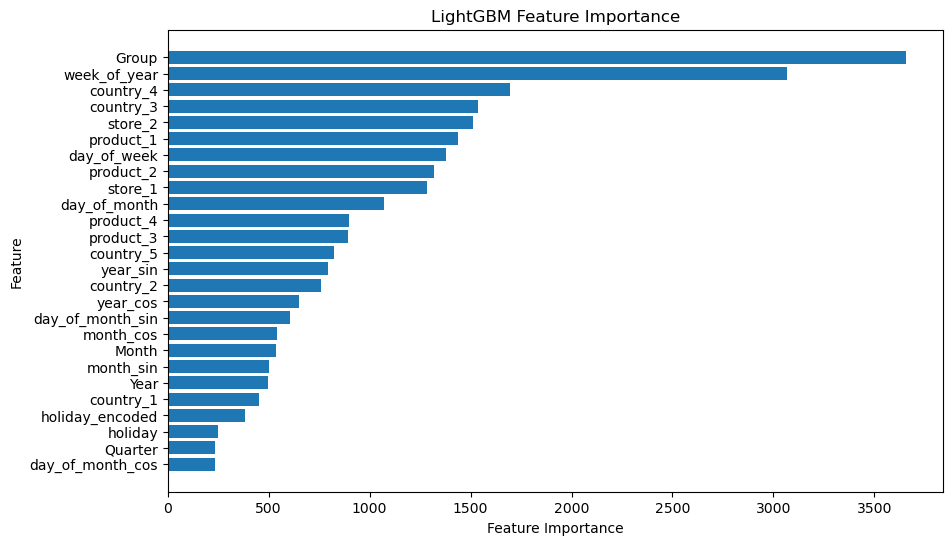

In [91]:
# Feature importance values
# importance = model.feature_importances_
importance = best_model.feature_importances_

# Feature names
feature_names = X.columns if isinstance(X, pd.DataFrame) else [f'Feature {i}' for i in range(X.shape[1])]

# Create a DataFrame for visualization
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("LightGBM Feature Importance")
plt.gca().invert_yaxis()
plt.show()

In [94]:
# Preprocess test data
test_features = test_df.drop(columns=['id', 'date'], errors='ignore')  # Drop unnecessary columns
# Apply encoding to the test set using the mapping from training data
test_features = test_features.reindex(columns=x_train.columns, fill_value=0)  # Align columns with training data

In [100]:
y_test_pred = best_model.predict(test_features)

In [102]:
sub = pd.read_csv(submission_path)
sub[target_variable] = np.expm1(y_test_pred)
sub.to_csv('Predictions_LGBM.csv', index=False)
print(sub.shape)
sub.head()

C:\Users\zchodan\AppData\Local\Temp\1\ipykernel_7272\21123771.py:2: RuntimeWarning: overflow encountered in expm1
  sub[target_variable] = np.expm1(y_test_pred)


(98550, 2)


,id,num_sold
0,230130,6.625833e+73
1,230131,inf
2,230132,inf
3,230133,8.645788e+185
4,230134,2.842462e+226
